In [1]:
%matplotlib inline

from __future__ import division
import numpy as np
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from scipy.signal import convolve2d
    
from menpo.image import Image
import menpo.io as mio
from menpo.landmark import labeller, ibug_face_66

#Load Images 

In [2]:
images = []
for i in mio.import_images('/data/PhD/DataBases/faces/lfpw/trainset/', verbose=True, 
                           max_images=10):
    
    i.crop_to_landmarks_proportion_inplace(1)
    i = i.rescale_landmarks_to_diagonal_range(100)
    labeller(i, 'PTS', ibug_face_66)
    if i.n_channels == 3:
        i = i.as_greyscale(mode='average')
    images.append(i)

- Loading 10 assets: [====================] 100%

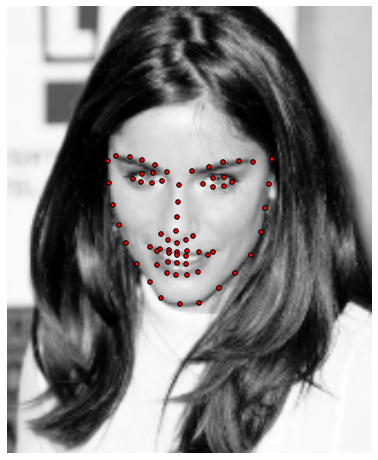

In [3]:
from menpo.visualize import visualize_images

visualize_images(images)

In [4]:
for key in i.landmarks.keys():
    i.landmarks[key].lms.points= i.landmarks[key].lms.points + 10

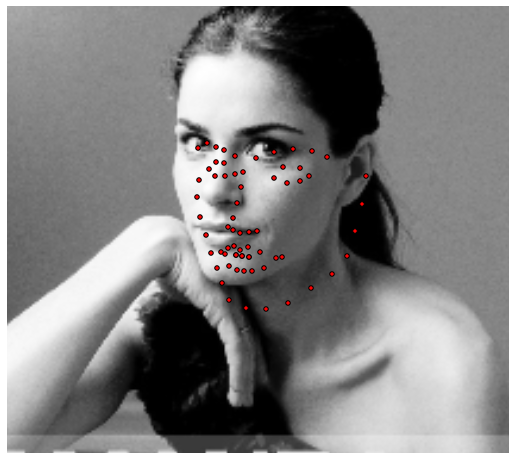

In [5]:
i.view_widget()

# Padding and cropping functions

In [6]:
from __future__ import division
import numpy as np


def pad_centre(pixels, ext_shape, mode='constant'):
    _, h, w = pixels.shape

    h_margin = (ext_shape[0] - h) // 2
    w_margin = (ext_shape[1] - w) // 2

    h_margin2 = h_margin
    if h + 2 * h_margin < ext_shape[0]:
        h_margin += 1

    w_margin2 = w_margin
    if w + 2 * w_margin < ext_shape[1]:
        w_margin += 1

    pad_width = ((0, 0), (h_margin, h_margin2), (w_margin, w_margin2))

    return np.lib.pad(pixels, pad_width, mode=mode)


def crop_centre(pixels, shape):
    _, h, w = pixels.shape

    h_margin = (h - shape[0]) // 2
    w_margin = (w - shape[1]) // 2
    
    h_corrector = 1 if np.remainder(h - shape[0], 2) != 0 else 0
    w_corrector = 1 if np.remainder(w - shape[1], 2) != 0 else 0
        
    return pixels[:, 
                  h_margin + h_corrector:-h_margin, 
                  w_margin + w_corrector:-w_margin]


def pad_bottomright(pixels, shape, mode='constant'):
    _, h, w = pixels.shape

    h_margin = shape[0] - h
    w_margin = shape[1] - w

    pad_width = ((0, 0), (0, h_margin), (0, w_margin))

    return np.lib.pad(pixels, pad_width, mode=mode)


def crop_bottomright(pixels, shape, f_shape):
    _, h, w = pixels.shape

    h_offset = f_shape[0] // 2
    w_offset = f_shape[1] // 2
    h_margin = h - shape[0]
    w_margin = w - shape[1]

    return pixels[:, 
                  h_offset:h_offset-h_margin, 
                  w_offset:w_offset-w_margin]

# Compute convolutions 

In [14]:
# image index
ind = 0

# filter type
filter_type = 'landmark'
l = 46

# whether to perform convolution or correlation
correlation = False

# scaling applyied to the extended shape
s = 1

# patch size
patch_size = (7, 7)

# padding type
mode = 'constant'

# whether to normalize the image and filter or not
normalize = False

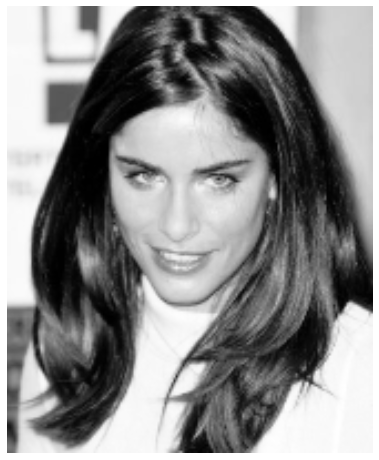

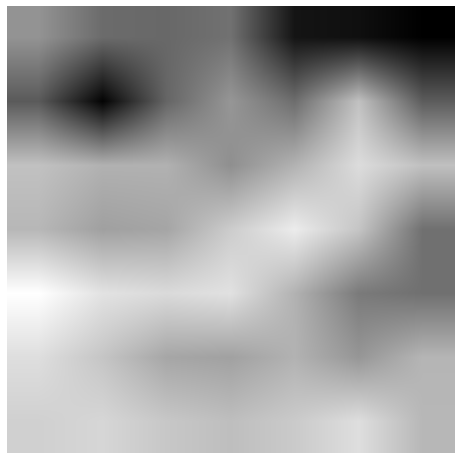

In [15]:
# select image
i = images[ind].copy()


if filter_type is 'random':
    # build random filter
    f = Image(np.random.randn(1, patch_size[0], patch_size[1]))
else:
    # extract filter around landmark
    f = i.extract_patches_around_landmarks(group='ibug_face_66', 
                                           patch_size=patch_size)[l].copy()
    
if correlation:
    # flip filter if correlation is required
    f = Image(f.pixels[0, ::-1, ::-1])

if normalize:
    # normalize image and filter if necessary
    i.mean_centre_inplace()
    f.mean_centre_inplace()

# visualize
i.view()
f.view(new_figure=True)

### Centre padded convolution

Original images shape is: 	(1, 202, 165)
Original filter shapes is: 	(1, 7, 7)
Extended image shape is: 	(1, 208, 171)
Extended filter shape is: 	(1, 208, 171)
Extended convolution shape is: 	(1, 208, 171)
Final convolution shapes is: 	(1, 202, 165)


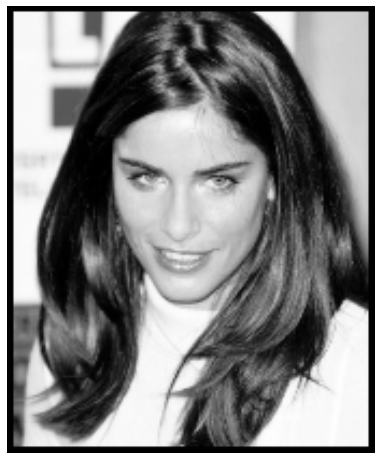

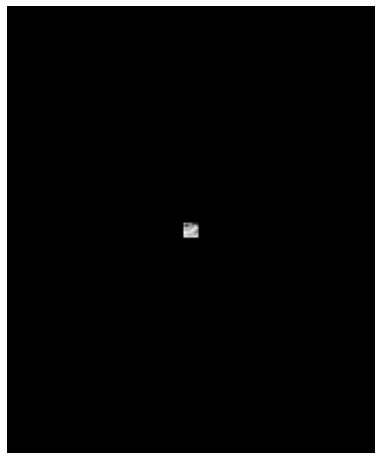

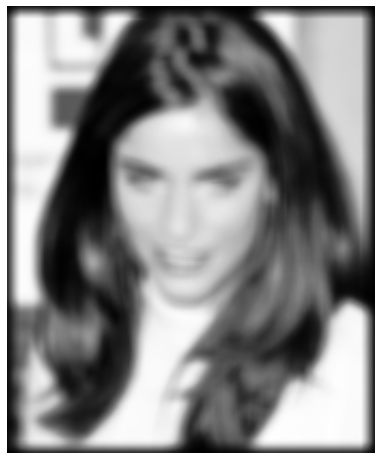

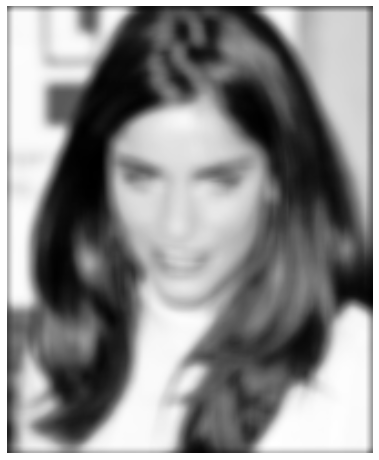

In [16]:
# extended shape
ext_h = i.shape[0] + f.shape[0] - 1
ext_w = i.shape[1] + f.shape[1] - 1
ext_shape = (s * ext_h, s * ext_w)

# extend image and filter
ext_i = pad_centre(i.pixels, ext_shape, mode=mode)
ext_f = pad_centre(f.pixels, ext_shape)

# compute ffts of extended image and extended filter
fft_ext_i = fft2(ext_i)
fft_ext_f = fft2(ext_f)

# compute extended convolution in Fourier domain
fft_ext_c = fft_ext_f * fft_ext_i

# compute ifft of extended convolution
ext_c1 =  np.real(ifftshift(ifft2(fft_ext_c), axes=(-2, -1)))

# crop extended convolution
c1 = crop_centre(ext_c1, i.shape)

# visualize
Image(ext_i).view()
Image(ext_f).view(new_figure=True)
Image(ext_c1).view(new_figure=True)
Image(c1).view(new_figure=True)

# info
print 'Original images shape is: \t', i.pixels.shape
print 'Original filter shapes is: \t', f.pixels.shape
print 'Extended image shape is: \t', ext_i.shape
print 'Extended filter shape is: \t', ext_f.shape
print 'Extended convolution shape is: \t', ext_c1.shape
print 'Final convolution shapes is: \t', c1.shape

### Bottom-right padded convolution 

Original images shape is: 	(1, 202, 165)
Original filter shapes is: 	(1, 7, 7)
Extended image shape is: 	(1, 208, 171)
Extended filter shape is: 	(1, 208, 171)
Extended convolution shape is: 	(1, 208, 171)
Final convolution shapes is: 	(1, 202, 165)


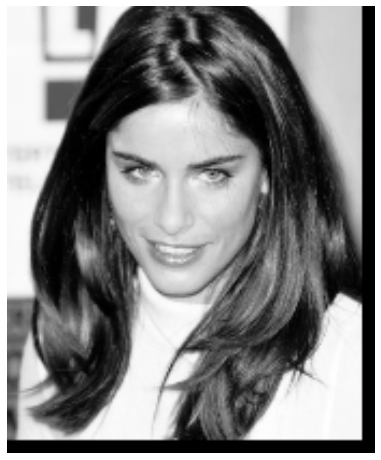

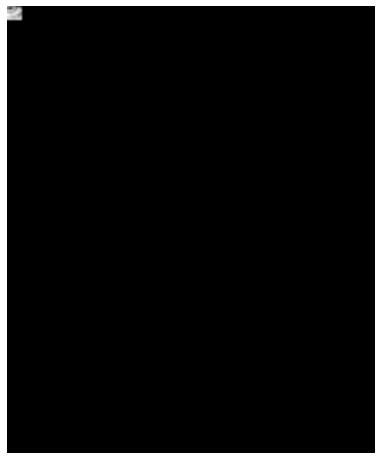

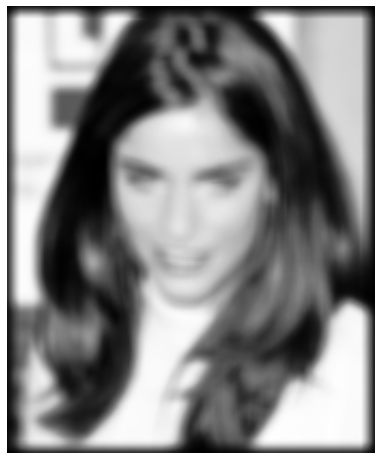

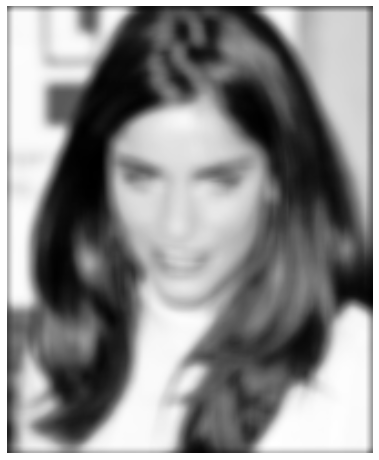

In [17]:
# extended shape
ext_h = i.shape[0] + f.shape[0] - 1
ext_w = i.shape[1] + f.shape[1] - 1
ext_shape = (s * ext_h, s * ext_w)

# extend image and filter
ext_i = pad_bottomright(i.pixels, ext_shape, mode=mode)
ext_f = pad_bottomright(f.pixels, ext_shape)

# compute ffts of extended image and extended filter
fft_ext_i = fft2(ext_i)
fft_ext_f = fft2(ext_f)

# compute extended convolution in Fourier domain
fft_ext_c = fft_ext_f * fft_ext_i

# compute ifft of extended convolution
ext_c2 =  np.real(ifft2(fft_ext_c))

# crop extended convolution
c2 = crop_bottomright(ext_c2, i.shape, f.shape)

# visualize
Image(ext_i).view()
Image(ext_f).view(new_figure=True)
Image(ext_c2).view(new_figure=True)
Image(c2).view(new_figure=True)

# info
print 'Original images shape is: \t', i.pixels.shape
print 'Original filter shapes is: \t', f.pixels.shape
print 'Extended image shape is: \t', ext_i.shape
print 'Extended filter shape is: \t', ext_f.shape
print 'Extended convolution shape is: \t', ext_c2.shape
print 'Final convolution shapes is: \t', c2.shape

### Spatial convolution using scipy

Original images shape is: 	(1, 202, 165)
Original filter shapes is: 	(1, 7, 7)
Final convolution shapes is: 	(202, 165)


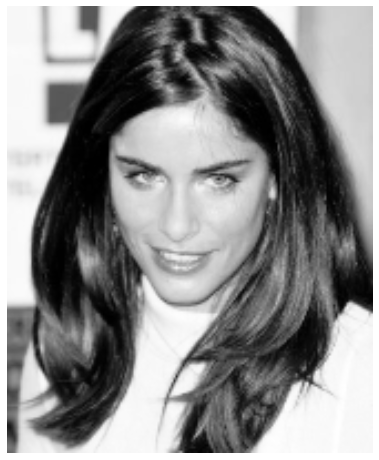

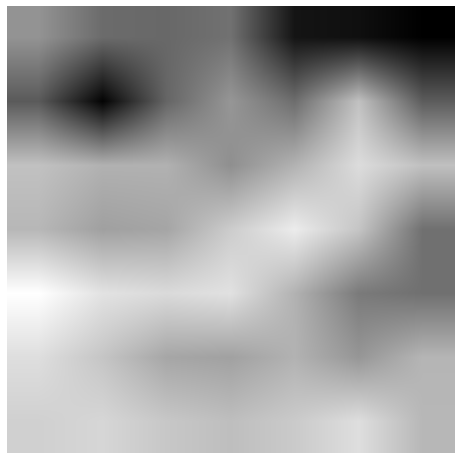

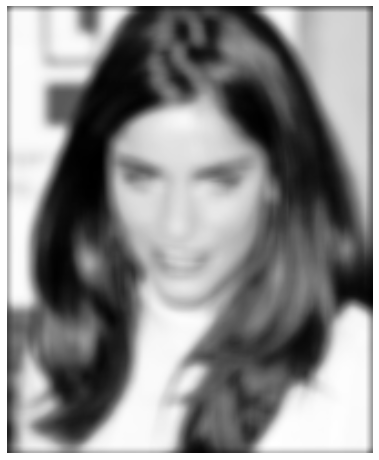

In [18]:
c3 = convolve2d(i.pixels[0], f.pixels[0], mode='same')

# visualize
i.view()
f.view(new_figure=True)
Image(c3).view(new_figure=True)

# info
print 'Original images shape is: \t', i.pixels.shape
print 'Original filter shapes is: \t', f.pixels.shape
print 'Final convolution shapes is: \t', c3.shape

### Check convolution results

In [19]:
print 'Centre padded convolution is equal to spatial convolution:', np.allclose(c1, c3)
print 'Bottom-right padded convolution is equal to spatial convolution:', np.allclose(c2, c3)
print 'Centre padded and bottom-right convolutions are equal:', np.allclose(c1, c2) 

Centre padded convolution is equal to spatial convolution: True
Bottom-right padded convolution is equal to spatial convolution: True
Centre padded and bottom-right convolutions are equal: True


# Convolution functions

In [37]:
from __future__ import division
import numpy as np
from numpy.fft import fft2, ifft2, ifftshift

from menpo.image import Image

def conv(i, f, mean_centre=False, correlation=False, mode='same', 
         boundary='constant'):
    if mean_centre:
        i = i.copy()
        f = f.copy()
        i.mean_centre_inplace()
        f.mean_centre_inplace()
        
    if correlation:
        f.pixels = f.pixels[:, ::-1, ::-1]
    
    # extended shape
    i_shape = np.asarray(i.shape)
    f_shape = np.asarray(f.shape)
    ext_shape = i_shape + f_shape - 1

    # extend image and filter
    ext_i = pad_centre(i.pixels, ext_shape, mode=boundary)
    ext_f = pad_centre(f.pixels, ext_shape)

    # compute ffts of extended image and extended filter
    fft_ext_i = fft2(ext_i)
    fft_ext_f = fft2(ext_f)

    # compute extended convolution in Fourier domain
    fft_ext_c = fft_ext_f * fft_ext_i

    # compute ifft of extended convolution
    ext_c =  np.real(ifftshift(ifft2(fft_ext_c), axes=(-2, -1)))

    if mode is 'full': 
        c = Image(ext_c)
        c.landmarks = i.landmarks
        for key in c.landmarks.keys():
            c.landmarks[key].lms.points += (f_shape - 1) // 2  
    elif mode is 'same':
        c = Image(crop_centre(ext_c, i_shape))
        c.landmarks = i.landmarks
    elif mode is 'valid':
        c = Image(crop_centre(ext_c, i_shape - f_shape + 1))
        c.landmarks = i.landmarks
        for key in c.landmarks.keys():
            c.landmarks[key].lms.points -= (f_shape - 1) // 2  
    else:
        raise ValueError(
            "mode={}, is not supported. The only supported "
            "modes are: 'full', 'same' and 'valid'.".format(mode)) 
        
    return c


def multiconvsum(i, fs, mean_centre=False, correlation=False, mode='same', 
                 boundary='constant'):
    if mean_centre:
        i = i.copy()
        i.mean_centre_inplace()
        
    # extended shape
    i_shape = np.asarray(i.shape)
    f_shape = np.asarray(fs[0].shape)
    ext_shape = i_shape + f_shape - 1

    # extend image
    ext_i = pad_centre(i.pixels, ext_shape, mode=boundary)
    # compute ffts of extended image
    fft_ext_i = fft2(ext_i)
    
    # initialize extended response shape
    ext_r = np.empty(np.hstack((len(fs), ext_shape)))
    for j, f in enumerate(fs):
        if mean_centre:
            f = f.copy()
            f.mean_centre_inplace()
        
        if correlation:
            f.pixels = f.pixels[:, ::-1, ::-1]
        
        # extend filter
        ext_f = pad_centre(f.pixels, ext_shape)
        # compute fft of filter
        fft_ext_f = fft2(ext_f)

        # compute extended convolution in Fourier domain
        fft_ext_c = np.sum(fft_ext_f * fft_ext_i, axis=0)

        # compute ifft of extended convolution
        ext_r[j] =  np.real(ifftshift(ifft2(fft_ext_c), axes=(-2, -1)))

    if mode is 'full': 
        r = Image(ext_r)
        r.landmarks = i.landmarks
        for key in r.landmarks.keys():
            r.landmarks[key].lms.points += (f_shape - 1) // 2  
    elif mode is 'same':
        r = Image(crop_centre(ext_r, i_shape))
        r.landmarks = i.landmarks
    elif mode is 'valid':
        r = Image(crop_centre(ext_r, i_shape - f_shape + 1))
        r.landmarks = i.landmarks
        for key in r.landmarks.keys():
            r.landmarks[key].lms.points -= (f_shape - 1) // 2  
    else:
        raise ValueError(
            "mode={}, is not supported. The only supported "
            "modes are: 'full', 'same' and 'valid'.".format(mode)) 

    return r
    
    
def multiconvlist(i, fs, mean_centre=False, correlation=False, mode='same', 
                  boundary='constant'):
    if mean_centre:
        i = i.copy()
        i.mean_centre_inplace()
        
    # extended shape
    i_shape = np.asarray(i.shape)
    f_shape = np.asarray(fs[0].shape)
    ext_shape = i_shape + f_shape - 1

    # extend image
    ext_i = pad_centre(i.pixels, ext_shape, mode=boundary)
    # compute ffts of extended image
    fft_ext_i = fft2(ext_i)
    
    # initialize responses list
    rs = []
    for j, f in enumerate(fs):
        if mean_centre:
            f = f.copy()
            f.mean_centre_inplace()
        
        if correlation:
            f.pixels = f.pixels[:, ::-1, ::-1]
        
        # extend filter
        ext_f = pad_centre(f.pixels, ext_shape)
        # compute fft of filter
        fft_ext_f = fft2(ext_f)

        # compute extended convolution in Fourier domain
        fft_ext_c = fft_ext_f * fft_ext_i

        # compute ifft of extended convolution
        ext_r =  np.real(ifftshift(ifft2(fft_ext_c), axes=(-2, -1)))

        if mode is 'full': 
            r = Image(ext_r)
            r.landmarks = i.landmarks
            for key in r.landmarks.keys():
                r.landmarks[key].lms.points += (f_shape - 1) // 2 
        elif mode is 'same':
            r = Image(crop_centre(ext_r, i_shape))
            r.landmarks = i.landmarks
        elif mode is 'valid':
            r = Image(crop_centre(ext_r, i_shape - f_shape + 1))
            r.landmarks = i.landmarks
            for key in r.landmarks.keys():
                r.landmarks[key].lms.points -= (f_shape - 1) // 2 
        else:
            raise ValueError(
                "mode={}, is not supported. The only supported "
                "modes are: 'full', 'same' and 'valid'.".format(mode))        
        
        # add r to response list
        rs.append(r)
        
    return rs

Final convolution shapes is: 	(1, 202, 165)


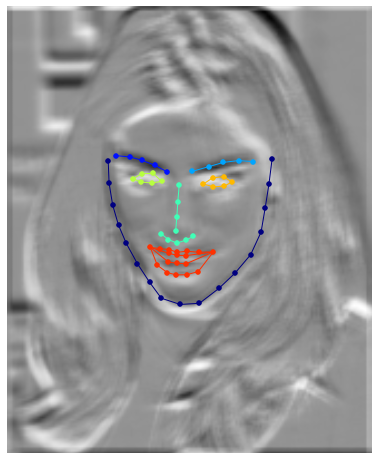

In [41]:
c4 = conv(i, f, mean_centre=True, correlation=True, mode='same', boundary='constant')

# visualize
c4.view_landmarks(group='ibug_face_66', new_figure=True)

# info
print 'Final convolution shapes is: \t', c4.pixels.shape

Final convolution shapes is: 	(2, 202, 165)


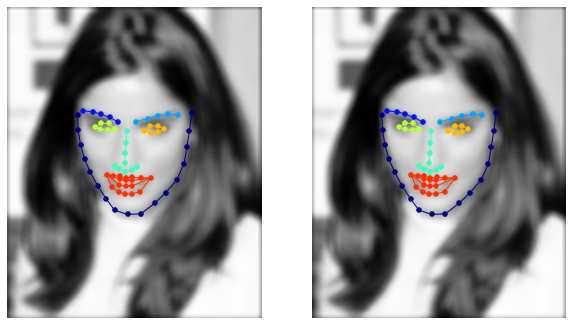

In [39]:
c5 = multiconvsum(i, [f, f], mode='same', boundary='constant')

# visualize
c5.view_landmarks(group='ibug_face_66', new_figure=True)

# info
print 'Final convolution shapes is: \t', c5.pixels.shape

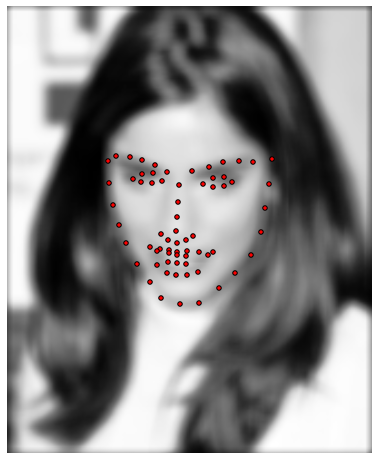

Final convolution shapes is: 	(1, 202, 165)


In [40]:
cs = multiconvlist(i, [f, f], mode='same', boundary='constant')

# visualize
visualize_images(cs)

# info
print 'Final convolution shapes is: \t', cs[0].pixels.shape

In [24]:
print np.allclose(c4.pixels, c5.pixels[0])
print np.allclose(c4.pixels, cs[0].pixels)
print np.allclose(c5.pixels[0], cs[0].pixels)

True
True
True
